In [6]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import umap.umap_ as umap

In [7]:
NO_DISEASE_COLOR = '#a1c9f4'  # Xanh pastel
DISEASE_COLOR = '#ff9f80'     # Cam pastel
COLOR_PALETTE = [NO_DISEASE_COLOR, DISEASE_COLOR]

In [ ]:
data = pd.read_csv('heart_disease_health_indicators_BRFSS2015.csv')
data.head()

,HeartDiseaseorAttack,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,Diabetes,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


In [76]:
X, y = data.drop('HeartDiseaseorAttack', axis=1), data['HeartDiseaseorAttack']

In [25]:
from sklearn.utils import resample

def resample_data(X, y):
    imbalanced_data = X.copy()
    imbalanced_data['HeartDiseaseorAttack'] = y.copy()

    minority_class = imbalanced_data[imbalanced_data['HeartDiseaseorAttack'] == 1.0]
    majority_class = imbalanced_data[imbalanced_data['HeartDiseaseorAttack'] == 0.0]

    # upsample the minority class
    minority_upsampled = resample(minority_class, replace=True, n_samples=len(majority_class), random_state=42)

    # combine the upsampled minority class with the majority class
    balanced_data = pd.concat([majority_class, minority_upsampled])
    X_ro, y_ro = balanced_data.drop('HeartDiseaseorAttack', axis=1), balanced_data['HeartDiseaseorAttack']
    return X_ro, y_ro


PCA on scaled data:
Shape of transformed data: (253680, 14)
Explained variance ratio: [0.16887932 0.08353438 0.06489342 0.05663571 0.05470661 0.05331009
 0.04691048 0.04505335 0.04400451 0.04200924 0.03894772 0.03755471
 0.03529163 0.03472346]
Cumulative explained variance: [0.16887932 0.2524137  0.31730712 0.37394283 0.42864944 0.48195953
 0.52887002 0.57392337 0.61792788 0.65993712 0.69888484 0.73643954
 0.77173118 0.80645463]


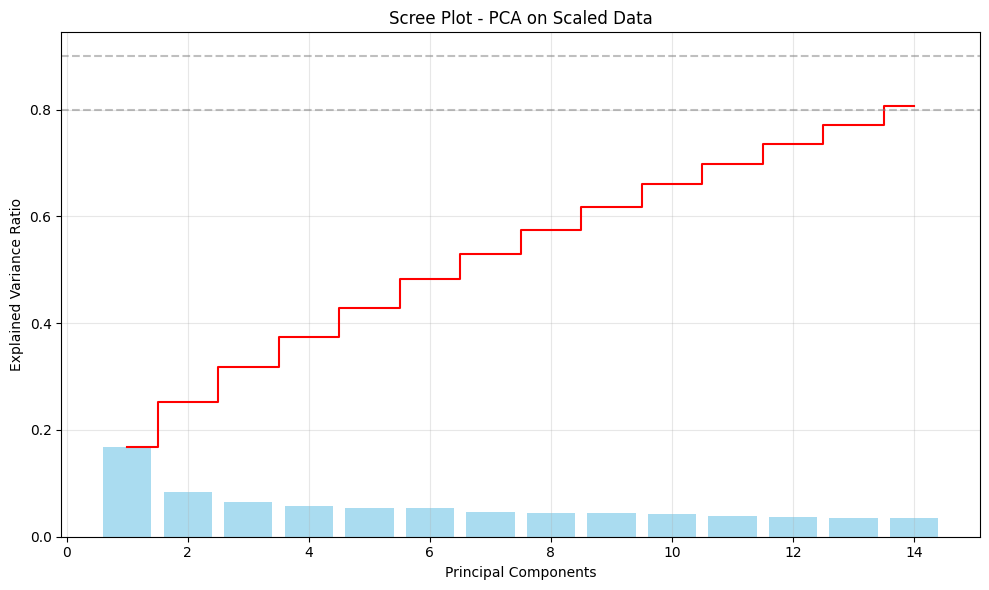

In [93]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=14)
pca_transformed = pca.fit_transform(X_scaled)

# explained variance
print("\nPCA on scaled data:")
print(f"Shape of transformed data: {pca_transformed.shape}")
explained_var = pca.explained_variance_ratio_
print(f"Explained variance ratio: {explained_var}")
print(f"Cumulative explained variance: {np.cumsum(explained_var)}")

# scree plot
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_var) + 1), explained_var, alpha=0.7, color='skyblue')
plt.step(range(1, len(explained_var) + 1), np.cumsum(explained_var), where='mid', color='red')
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot - PCA on Scaled Data')
plt.axhline(y=0.8, color='gray', linestyle='--', alpha=0.5)
plt.axhline(y=0.9, color='gray', linestyle='--', alpha=0.5)
plt.grid(True, alpha=0.3)
plt.tight_layout()

Thử sử dụng chiều 14 so với chiều 6

In [84]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((177576, 21), (76104, 21), (177576,), (76104,))

In [85]:
X_train_ro, y_train_ro = resample_data(X_train, y_train)
X_train_ro.shape, y_train_ro.shape

((321702, 21), (321702,))

In [87]:
scaler = StandardScaler()
pca = LinearDiscriminantAnalysis(n_components=1)
X_train_scale_6 = pca.fit_transform(scaler.fit_transform(X_train_ro), y_train_ro)
print(X_train_scale_6.shape)
X_test_scale_6 = pca.transform(scaler.transform(X_test))
print(X_test_scale_6.shape)

scaler = StandardScaler()
pca = PCA(n_components=14)
X_train_scale_14 = pca.fit_transform(scaler.fit_transform(X_train_ro))
print(X_train_scale_14.shape)
X_test_scale_14 = pca.transform(scaler.transform(X_test))
print(X_test_scale_14.shape)

(321702, 1)
(76104, 1)
(321702, 14)
(76104, 14)


In [88]:
from sklearn.neighbors import KNeighborsClassifier, NeighborhoodComponentsAnalysis
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
import math

k = int(math.sqrt(X_train_scale_6.shape[0]))
knn = KNeighborsClassifier(n_neighbors=k, weights='distance')

knn.fit(X_train_scale_6, y_train_ro)

## evaluate
y_pred = knn.predict(X_test_scale_6)
print(f1_score(y_test, y_pred))
print(precision_score(y_test, y_pred))
print(recall_score(y_test, y_pred))

0.3550245359505014
0.23823613629855875
0.6964285714285714


In [90]:
k = int(math.sqrt(X_train_ro.shape[0]))
knn = KNeighborsClassifier(n_neighbors=k, weights='distance')

knn.fit(X_train_ro, y_train_ro)

## evaluate
y_pred = knn.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.97      0.69      0.81     68936
         1.0       0.21      0.79      0.33      7168

    accuracy                           0.70     76104
   macro avg       0.59      0.74      0.57     76104
weighted avg       0.90      0.70      0.76     76104



In [91]:
print(f1_score(y_test, y_pred))
print(precision_score(y_test, y_pred))
print(recall_score(y_test, y_pred))

0.3307215530347328
0.2092025447551413
0.7890625


In [78]:
from sklearn.linear_model import LogisticRegression

scaler = StandardScaler()
pca = PCA(n_components=6)
X_train_scale_6 = pca.fit_transform(scaler.fit_transform(X_train))
print(X_train_scale_6.shape)
X_test_scale_6 = pca.transform(scaler.transform(X_test))
print(X_test_scale_6.shape)

scaler = StandardScaler()
pca = PCA(n_components=14)
X_train_scale_14 = pca.fit_transform(scaler.fit_transform(X_train))
print(X_train_scale_14.shape)
X_test_scale_14 = pca.transform(scaler.transform(X_test))
print(X_test_scale_14.shape)

lr = LogisticRegression(class_weight='balanced')
lr.fit(X_train_scale_6, y_train)
y_pred = lr.predict(X_test_scale_6)
print(f1_score(y_test, y_pred))
print(precision_score(y_test, y_pred))
print(recall_score(y_test, y_pred))

(177576, 6)
(76104, 6)
(177576, 14)
(76104, 14)
0.35747693906716904
0.2329805249788315
0.7677176339285714


In [77]:
lr = LogisticRegression(class_weight='balanced')
lr.fit(X_train_scale_14, y_train)
y_pred = lr.predict(X_test_scale_14)
print(f1_score(y_test, y_pred))
print(precision_score(y_test, y_pred))
print(recall_score(y_test, y_pred))

0.37080030513084145
0.24322325196884653
0.7798549107142857


In [80]:
lr = LogisticRegression(class_weight='balanced')
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print(f1_score(y_test, y_pred))
print(precision_score(y_test, y_pred))
print(recall_score(y_test, y_pred))

0.3709903279382551
0.24198139258252263
0.7946428571428571


In [79]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler
scaler = MinMaxScaler()
lda = LinearDiscriminantAnalysis(n_components=1)
X_train_lda = lda.fit_transform(scaler.fit_transform(X_train), y_train)
X_test_lda = lda.transform(scaler.transform(X_test))

lr = LogisticRegression(class_weight="balanced")
lr.fit(X_train_lda, y_train)

y_pred = lr.predict(X_test_lda)
print(f1_score(y_test, y_pred))
print(precision_score(y_test, y_pred))
print(recall_score(y_test, y_pred))

0.3843627502913444
0.25731713083360913
0.7592075892857143
